In [16]:
# STEP 1: UPLOAD CSV FILE
from google.colab import files
import pandas as pd

uploaded = files.upload()

# Automatically get the file name
file_name = list(uploaded.keys())[0]

# Read the CSV
df = pd.read_csv(file_name)

# Preview the data
df.head()


Saving MIS78_Water_Indicators.csv to MIS78_Water_Indicators (1).csv


,State,Age Group,Sector,Gender,Indicator,Value
0,All India,15 years and above,All,Male,Percentage of Persons Who Used Mobile Telephon...,83.2
1,All India,15 years and above,All,Female,Percentage of Persons Who Used Mobile Telephon...,56.7
2,All India,15 years and above,All,Person,Percentage of Persons Who Used Mobile Telephon...,70.2
3,All India,15 years and above,Rural,Male,Percentage of Persons Who Used Mobile Telephon...,80.2
4,All India,15 years and above,Rural,Female,Percentage of Persons Who Used Mobile Telephon...,49.9


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# STEP 1: Load your dataset (replace with your actual file path if needed)
file_path = "MIS78_Water_Indicators.csv"
df = pd.read_csv(file_path)

# STEP 2: Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_')
print("Cleaned Columns:\n", df.columns.tolist())
df.tail()

Cleaned Columns:
 ['state', 'age_group', 'sector', 'gender', 'indicator', 'value']


,state,age_group,sector,gender,indicator,value
661,West Bengal,18 years and above,Rural,Female,Percentage of Persons Who Used Mobile Telephon...,54.7
662,West Bengal,18 years and above,Rural,Person,Percentage of Persons Who Used Mobile Telephon...,70.4
663,West Bengal,18 years and above,Urban,Male,Percentage of Persons Who Used Mobile Telephon...,92.7
664,West Bengal,18 years and above,Urban,Female,Percentage of Persons Who Used Mobile Telephon...,77.4
665,West Bengal,18 years and above,Urban,Person,Percentage of Persons Who Used Mobile Telephon...,85.2


In [20]:
if 'indicator' in df.columns and 'value' in df.columns:
    pivot_df = df.pivot_table(index=['state', 'sector', 'gender'], columns='indicator', values='value').reset_index()
    pivot_df.columns = [str(col).lower().replace(' ', '_').replace('%', '').replace('.', '').replace('/', '_') for col in pivot_df.columns]
    print("\nPivoted Columns:\n", pivot_df.columns.tolist())
else:
    print("\n'indicator' and 'value' columns not found. Cannot pivot.")
    pivot_df = df.copy()


Pivoted Columns:
 ['state', 'sector', 'gender', 'percentage_of_persons_who_used_mobile_telephone_with_active_sim_card_at_least_once_during_last_three_months_preceding_the_date_of_the_survey']


In [22]:
water_col = None
fuel_col = None

for col in pivot_df.columns:
    if 'improved_source_of_drinking_water' in col:
        water_col = col
    if 'clean_fuel' in col or 'clean_fuel_for_cooking' in col:
        fuel_col = col
if not water_col or not fuel_col:
    print("\nRequired indicators not found in dataset.")
    print("Looked for columns like '...improved_source_of_drinking_water' and '...clean_fuel...'")
    print("Available indicators:", pivot_df.columns)
else:
    print("\nUsing columns:")
    print("   Water Access:", water_col)
    print("   Clean Fuel:  ", fuel_col)



Required indicators not found in dataset.
Looked for columns like '...improved_source_of_drinking_water' and '...clean_fuel...'
Available indicators: Index(['state', 'sector', 'gender',
       'percentage_of_persons_who_used_mobile_telephone_with_active_sim_card_at_least_once_during_last_three_months_preceding_the_date_of_the_survey'],
      dtype='object')


In [23]:
pivot_df.rename(columns={water_col: 'water_access', fuel_col: 'clean_fuel'}, inplace=True)
    # STEP 5: Encode categorical variables
pivot_df['sector'] = pivot_df['sector'].map({'Rural': 0, 'Urban': 1, 'All': 2})
pivot_df['gender'] = pivot_df['gender'].map({'Male': 0, 'Female': 1, 'Person': 2})



In [28]:
print("Available columns:", pivot_df.columns.tolist())  # Debug line
model_df = pivot_df[['sector', 'gender', 'percentage_of_persons_who_used_mobile_telephone_with_active_sim_card_at_least_once_during_last_three_months_preceding_the_date_of_the_survey']].dropna()


Available columns: ['state', 'sector', 'gender', 'percentage_of_persons_who_used_mobile_telephone_with_active_sim_card_at_least_once_during_last_three_months_preceding_the_date_of_the_survey']


In [31]:
# Rename the long column to 'mobile_usage'
pivot_df.rename(columns={
    'percentage_of_persons_who_used_mobile_telephone_with_active_sim_card_at_least_once_during_last_three_months_preceding_the_date_of_the_survey': 'mobile_usage'
}, inplace=True)

# Prepare model data
model_df = pivot_df[['sector', 'gender', 'mobile_usage']].dropna()

# Set features and target
X = model_df[['sector', 'gender']]
y = model_df['mobile_usage']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train models
lr = LinearRegression().fit(X_train, y_train)
tree = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)

# Make predictions
lr_pred = lr.predict(X_test)
tree_pred = tree.predict(X_test)


In [32]:
def evaluate_model(name, actual, predicted):
    print(f"\n📊 {name} Performance:")
    print("R² Score:", round(r2_score(actual, predicted), 3))
    print("MAE:", round(mean_absolute_error(actual, predicted), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(actual, predicted)), 2))
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Decision Tree", y_test, tree_pred)



📊 Linear Regression Performance:
R² Score: 0.01
MAE: 10.79
RMSE: 14.75

📊 Decision Tree Performance:
R² Score: 0.38
MAE: 9.03
RMSE: 11.67


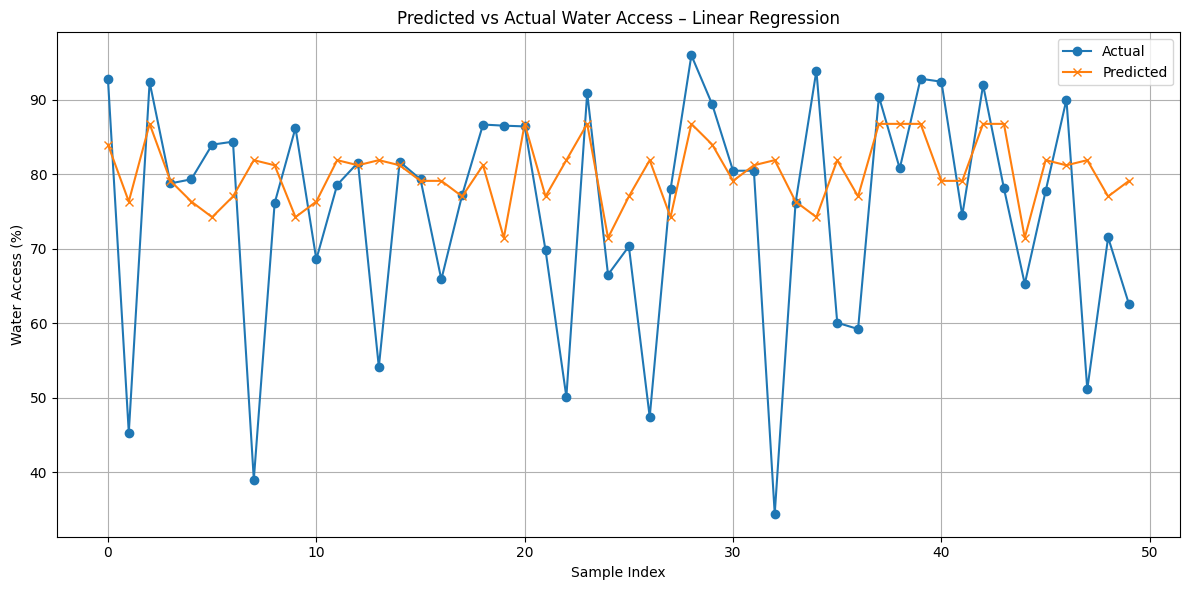

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(lr_pred[:50], label='Predicted', marker='x')
plt.title("Predicted vs Actual Water Access – Linear Regression")
plt.xlabel("Sample Index")
plt.ylabel("Water Access (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


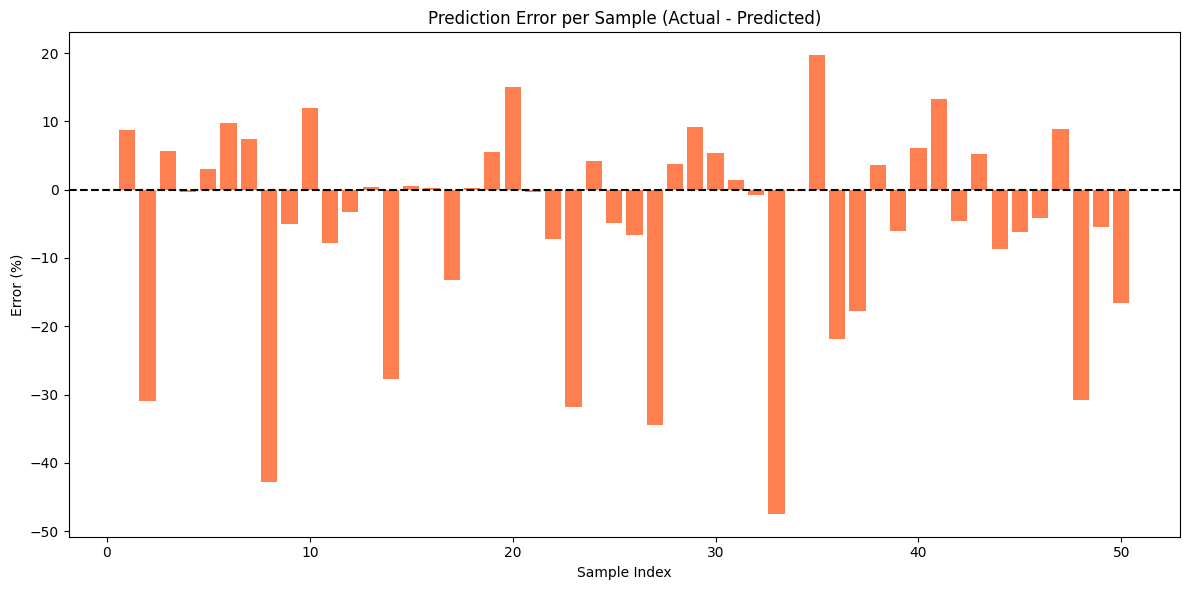

In [34]:
error = y_test.values[:50] - lr_pred[:50]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 51), error, color='coral')
plt.axhline(0, linestyle='--', color='black')
plt.title("Prediction Error per Sample (Actual - Predicted)")
plt.xlabel("Sample Index")
plt.ylabel("Error (%)")
plt.tight_layout()
plt.show()

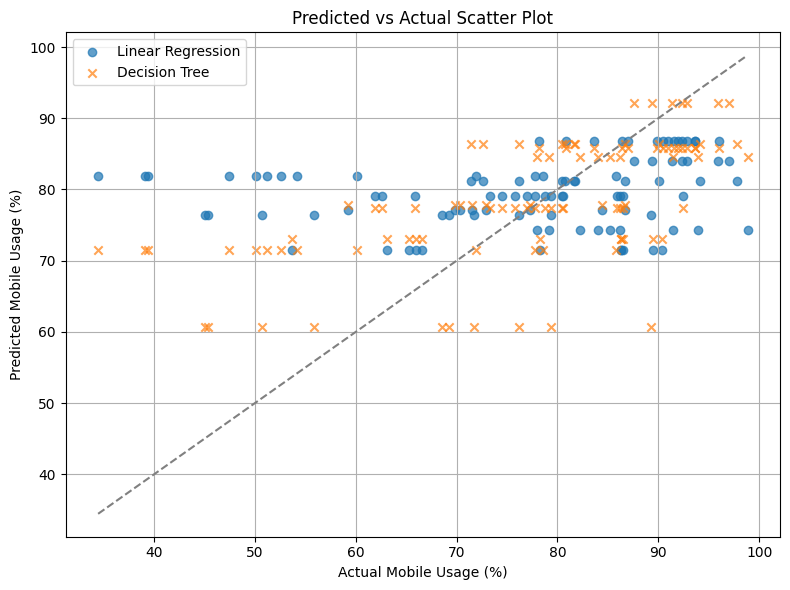

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, lr_pred, label='Linear Regression', alpha=0.7)
plt.scatter(y_test, tree_pred, label='Decision Tree', alpha=0.7, marker='x')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='gray', linestyle='--')
plt.xlabel("Actual Mobile Usage (%)")
plt.ylabel("Predicted Mobile Usage (%)")
plt.title("Predicted vs Actual Scatter Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


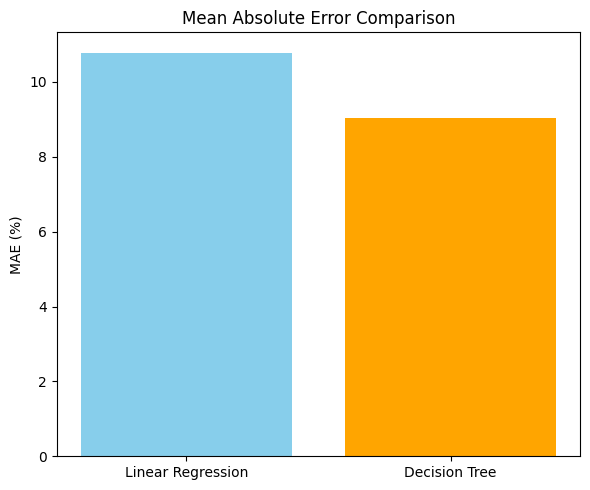

In [37]:
mae_lr = mean_absolute_error(y_test, lr_pred)
mae_tree = mean_absolute_error(y_test, tree_pred)

plt.figure(figsize=(6, 5))
plt.bar(['Linear Regression', 'Decision Tree'], [mae_lr, mae_tree], color=['skyblue', 'orange'])
plt.title("Mean Absolute Error Comparison")
plt.ylabel("MAE (%)")
plt.tight_layout()
plt.show()